In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

warnings.filterwarnings("ignore")

# Preprocessing

In [2]:
df = pd.read_csv("pengeluaran.csv")
df.head()

,id_pengeluaran,id_user,kategori,jumlah,tanggal
0,1,1,Makanan dan Minuman,10000,1/4/2024
1,2,1,Makanan dan Minuman,12000,1/4/2024
2,3,1,Paket Internet,50000,1/4/2024
3,4,1,Kos,500000,1/4/2024
4,5,1,Makanan dan Minuman,15000,2/4/2024


In [3]:
df['kategori'].value_counts()

kategori
Makanan dan Minuman    458
Lainnya                 71
Transportasi            48
Kebutuhan Akademik      21
Paket Internet          13
Kos                     13
Kesehatan                5
Name: count, dtype: int64

In [4]:
# Ubah kolom 'tanggal' menjadi datetime
df['tanggal'] = pd.to_datetime(df['tanggal'], dayfirst=True)

# Tambahkan kolom 'bulan' untuk agregasi bulanan
df['bulan'] = df['tanggal'].dt.to_period('M')

monthly_expenses = df.groupby(['bulan', 'kategori'])['jumlah'].sum().reset_index()

# Ubah kolom 'bulan' ke format datetime
monthly_expenses['bulan'] = monthly_expenses['bulan'].dt.to_timestamp()

monthly_expenses = monthly_expenses.pivot(index='bulan', columns='kategori', values='jumlah')
monthly_expenses

kategori,Kebutuhan Akademik,Kesehatan,Kos,Lainnya,Makanan dan Minuman,Paket Internet,Transportasi
bulan,,,,,,,
2024-04-01,NaN,NaN,500000.0,90000.0,578000.0,50000.0,67000.0
2024-05-01,39000.0,15000.0,500000.0,80000.0,560000.0,50000.0,55000.0
2024-06-01,15000.0,NaN,500000.0,65000.0,553000.0,50000.0,50000.0
2024-07-01,36000.0,20000.0,500000.0,75000.0,516000.0,50000.0,55000.0
2024-08-01,5000.0,NaN,500000.0,92000.0,499000.0,50000.0,90000.0
2024-09-01,39000.0,NaN,500000.0,115000.0,539000.0,50000.0,20000.0
2024-10-01,5000.0,10000.0,500000.0,95000.0,547000.0,50000.0,15000.0
2024-11-01,45000.0,NaN,500000.0,80000.0,498000.0,50000.0,75000.0
2024-12-01,5000.0,50000.0,500000.0,130000.0,514000.0,50000.0,15000.0


In [5]:
monthly_expenses.describe()

kategori,Kebutuhan Akademik,Kesehatan,Kos,Lainnya,Makanan dan Minuman,Paket Internet,Transportasi
count,12.000000,5.00000,13.0,13.000000,13.000000,13.0,13.000000
mean,20666.666667,29000.00000,500000.0,97230.769231,530923.076923,50000.0,45384.615385
std,15610.796575,19493.58869,0.0,26686.931403,29862.076112,0.0,23257.753050
min,5000.000000,10000.00000,500000.0,57000.000000,476000.000000,50000.0,15000.000000
25%,5000.000000,15000.00000,500000.0,80000.000000,514000.000000,50000.0,30000.000000
50%,16000.000000,20000.00000,500000.0,92000.000000,536000.000000,50000.0,48000.000000
75%,36750.000000,50000.00000,500000.0,115000.000000,553000.000000,50000.0,55000.000000
max,45000.000000,50000.00000,500000.0,142000.000000,578000.000000,50000.0,90000.000000


In [6]:
monthly_expenses.duplicated().sum()

0

In [7]:
monthly_expenses.isnull().sum()

kategori
Kebutuhan Akademik     1
Kesehatan              8
Kos                    0
Lainnya                0
Makanan dan Minuman    0
Paket Internet         0
Transportasi           0
dtype: int64

In [8]:
monthly_expenses = monthly_expenses.fillna(0)
monthly_expenses.isnull().sum()

kategori
Kebutuhan Akademik     0
Kesehatan              0
Kos                    0
Lainnya                0
Makanan dan Minuman    0
Paket Internet         0
Transportasi           0
dtype: int64

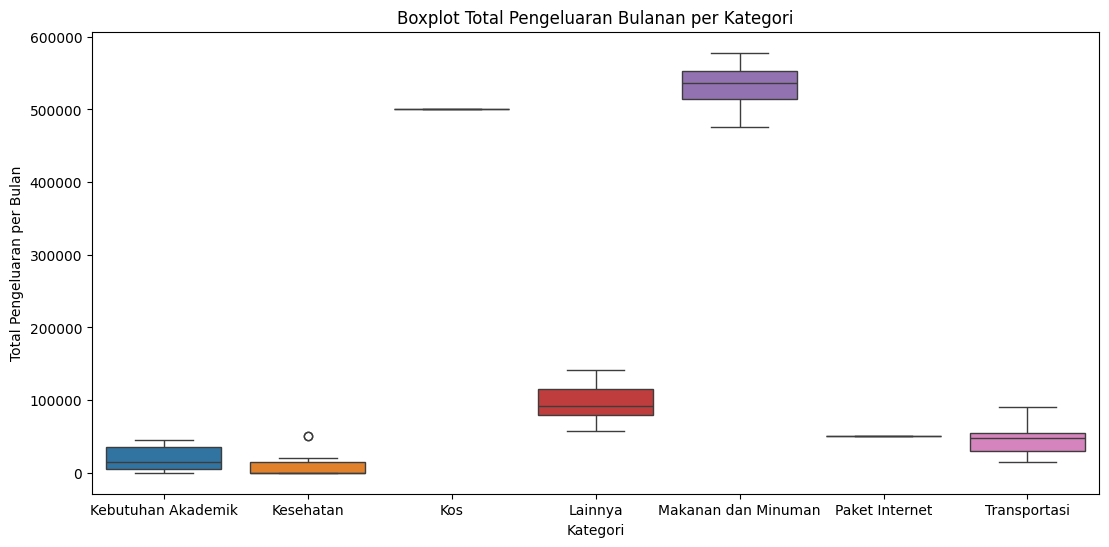

In [9]:
# Boxplot perkategori perbulan
plt.figure(figsize=(13, 6))
sns.boxplot(data=monthly_expenses)
plt.title('Boxplot Total Pengeluaran Bulanan per Kategori')
plt.xlabel('Kategori')
plt.ylabel('Total Pengeluaran per Bulan')
plt.show()

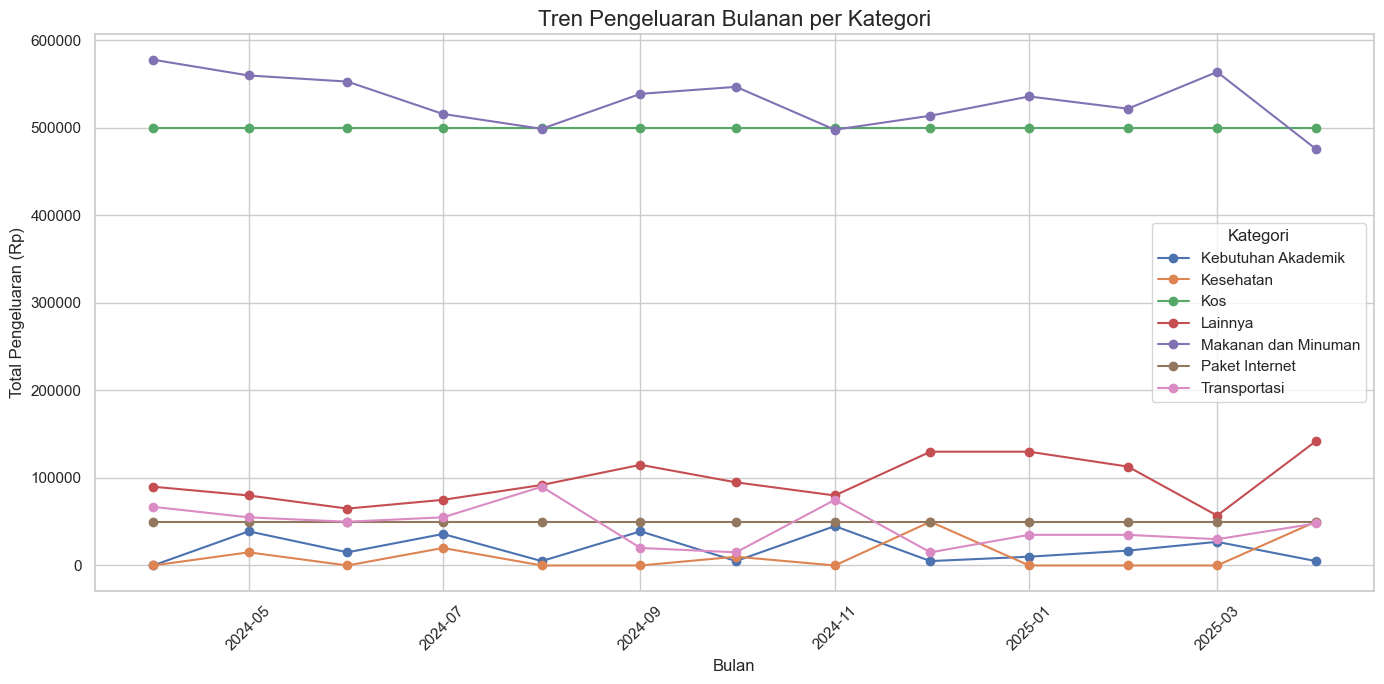

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Plot tren pengeluaran untuk setiap kategori
for kategori in monthly_expenses.columns:
    plt.plot(monthly_expenses.index, monthly_expenses[kategori], marker='o', label=kategori)

plt.title('Tren Pengeluaran Bulanan per Kategori', fontsize=16)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Total Pengeluaran (Rp)', fontsize=12)
plt.legend(title='Kategori')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
def plot_kategori_tren(data, kategori):
    if kategori not in data.columns:
        print(f"Kategori '{kategori}' tidak ditemukan dalam data.")
        return

    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 7))
    
    plt.plot(data.index, data[kategori], marker='o')
    
    plt.title(f'Tren Pengeluaran Bulanan Kategori {kategori}', fontsize=16)
    plt.xlabel('Bulan', fontsize=12)
    plt.ylabel('Total Pengeluaran (Rp)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

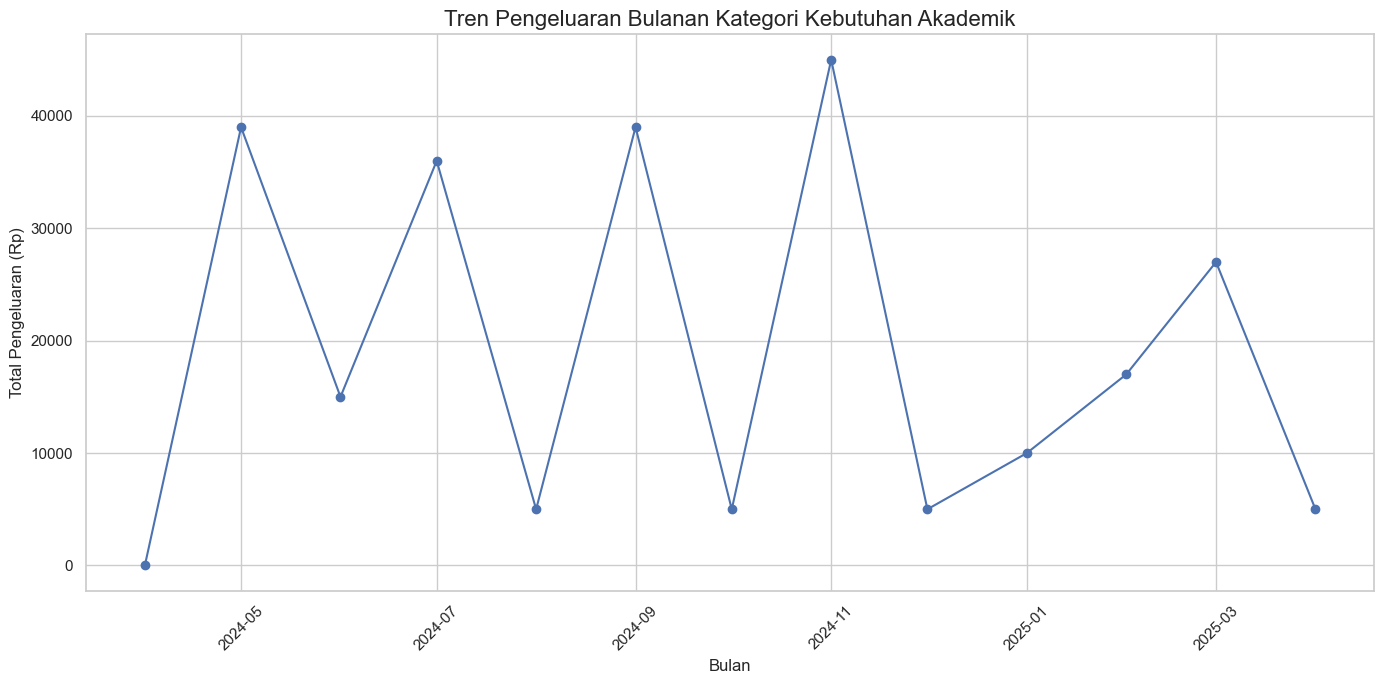

In [12]:
plot_kategori_tren(monthly_expenses, 'Kebutuhan Akademik')

# Splitting data

In [13]:
kategori = 'Kebutuhan Akademik'
data_kategori = monthly_expenses[kategori]

train = data_kategori[:-1]
test = data_kategori[-1:]

print("Train data:")
print(train.tail())
print("\nTest data:")
print(test)

Train data:
bulan
2024-11-01    45000.0
2024-12-01     5000.0
2025-01-01    10000.0
2025-02-01    17000.0
2025-03-01    27000.0
Name: Kebutuhan Akademik, dtype: float64

Test data:
bulan
2025-04-01    5000.0
Name: Kebutuhan Akademik, dtype: float64


# Modelling

In [14]:
results = {}

# ==== ARIMA ====
model_arima = ARIMA(train, order=(1,1,1))
fit_arima = model_arima.fit()
pred_train_arima = fit_arima.predict(start=train.index[1], end=train.index[-1])
pred_test_arima = fit_arima.forecast(steps=1)

rmse_train_arima = np.sqrt(mean_squared_error(train[1:], pred_train_arima))
rmse_test_arima = np.sqrt(mean_squared_error(test, pred_test_arima))

results['ARIMA'] = (rmse_train_arima, rmse_test_arima)

In [15]:
# ==== SARIMA ====
model_sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
fit_sarima = model_sarima.fit(disp=False)
pred_train_sarima = fit_sarima.predict(start=train.index[1], end=train.index[-1])
pred_test_sarima = fit_sarima.forecast(steps=1)

rmse_train_sarima = np.sqrt(mean_squared_error(train[1:], pred_train_sarima))
rmse_test_sarima = np.sqrt(mean_squared_error(test, pred_test_sarima))

results['SARIMA'] = (rmse_train_sarima, rmse_test_sarima)

In [16]:
# ==== Simple Exponential Smoothing ====
model_ses = SimpleExpSmoothing(train)
fit_ses = model_ses.fit()
pred_train_ses = fit_ses.fittedvalues
pred_test_ses = fit_ses.forecast(1)

rmse_train_ses = np.sqrt(mean_squared_error(train, pred_train_ses))
rmse_test_ses = np.sqrt(mean_squared_error(test, pred_test_ses))

results['SES'] = (rmse_train_ses, rmse_test_ses)

In [17]:
# ==== Holt-Winters ====
model_hw = ExponentialSmoothing(train, trend='add', seasonal=None, seasonal_periods=3)
fit_hw = model_hw.fit()
pred_train_hw = fit_hw.fittedvalues
pred_test_hw = fit_hw.forecast(1)

rmse_train_hw = np.sqrt(mean_squared_error(train, pred_train_hw))
rmse_test_hw = np.sqrt(mean_squared_error(test, pred_test_hw))

results['Holt-Winters'] = (rmse_train_hw, rmse_test_hw)

In [18]:
# ==== Tampilkan hasil ====
print("RMSE per model (Train dan Test):\n")
for model_name, (rmse_train, rmse_test) in results.items():
    print(f"{model_name}: RMSE Train = {rmse_train:.2f}, RMSE Test = {rmse_test:.2f}")

RMSE per model (Train dan Test):

ARIMA: RMSE Train = 17490.12, RMSE Test = 9714.04
SARIMA: RMSE Train = 28896.37, RMSE Test = 22000.00
SES: RMSE Train = 19398.69, RMSE Test = 14325.85
Holt-Winters: RMSE Train = 15533.54, RMSE Test = 12350.82


# TUNING

In [19]:
# Grid Search ARIMA
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_score = float("inf")
best_cfg = None
results = []

for param in pdq:
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit()
        
        forecast = model_fit.forecast(steps=1)

        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        
        results.append((param, mae, rmse))
        
        if rmse < best_score:
            best_score = rmse
            best_cfg = param
        
    except Exception as e:
        continue

results_df = pd.DataFrame(results, columns=["ARIMA_order", "MAE", "RMSE"])
results_df = results_df.sort_values(by="RMSE").reset_index(drop=True)

print(f"\n Best ARIMA order: {best_cfg} with RMSE: {best_score:.2f}\n")
print(results_df.head())


 Best ARIMA order: (2, 1, 2) with RMSE: 6282.74

  ARIMA_order          MAE         RMSE
0   (2, 1, 2)  6282.739394  6282.739394
1   (2, 0, 2)  7072.744164  7072.744164
2   (1, 0, 2)  8073.697628  8073.697628
3   (1, 1, 2)  8941.551267  8941.551267
4   (1, 1, 1)  9714.036086  9714.036086


In [20]:
def plot_learning_curve_arima(data, order, min_train_size=6, title="Learning Curve ARIMA"):
    train_sizes = []
    train_rmse = []
    test_rmse = []

    for train_end in range(min_train_size, len(data) - 1):
        train = data[:train_end]
        test = data[train_end:train_end+1]

        try:
            model = ARIMA(train, order=order)
            model_fit = model.fit()

            # In-sample prediction (hindari prediksi awal karena ARIMA butuh burn-in)
            pred_train = model_fit.predict(start=train.index[1], end=train.index[-1])
            rmse_train = np.sqrt(mean_squared_error(train[1:], pred_train))

            # Forecast 1 langkah ke depan
            forecast = model_fit.forecast(steps=1)
            rmse_test = np.sqrt(mean_squared_error(test, forecast))

            # Simpan hasil
            train_sizes.append(train_end)
            train_rmse.append(rmse_train)
            test_rmse.append(rmse_test)

        except Exception as e:
            continue

    # Plot
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Jumlah Data Latih (Bulan)")
    plt.ylabel("RMSE")
    plt.grid(True)

    plt.plot(train_sizes, train_rmse, 'o-', color="r", label="Training RMSE")
    plt.plot(train_sizes, test_rmse, 'o-', color="g", label="Testing RMSE")

    plt.fill_between(train_sizes, np.array(train_rmse), np.array(train_rmse), alpha=0.1, color="r")
    plt.fill_between(train_sizes, np.array(test_rmse), np.array(test_rmse), alpha=0.1, color="g")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

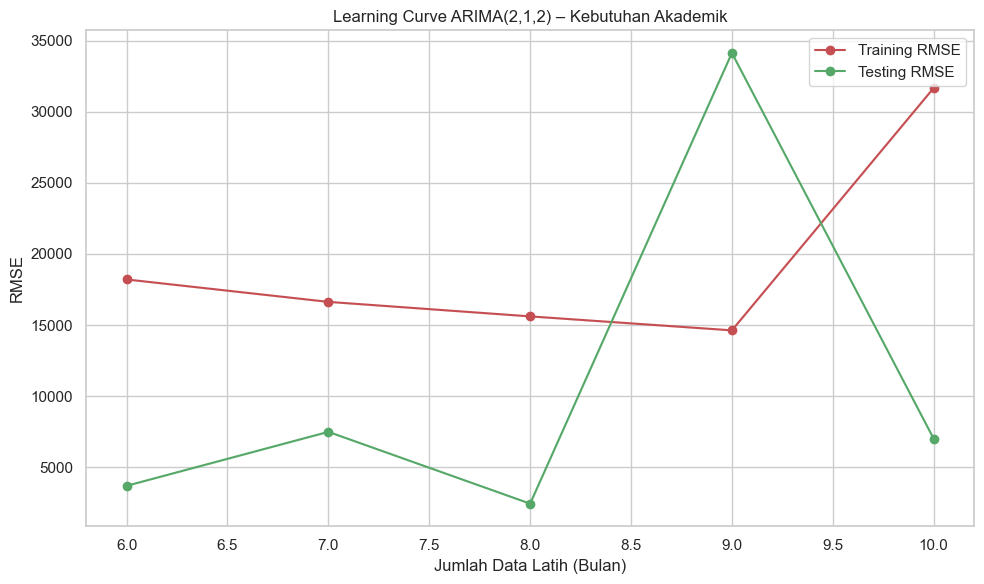

In [21]:
plot_learning_curve_arima(data=data_kategori, order=best_cfg, title="Learning Curve ARIMA(2,1,2) – Kebutuhan Akademik")

In [22]:
# Prediksi bulan selanjutnya (satu langkah ke depan)
model = ARIMA(train, order=best_cfg)
model_fit = model.fit()

forecast = model_fit.forecast(steps=1)
forecast_value = forecast.values[0]
forecast_date = test.index[0]
print(f"Prediksi bulan {forecast_date.strftime('%B %Y')}: Rp{forecast.iloc[0]:,.0f}")

Prediksi bulan April 2025: Rp11,283


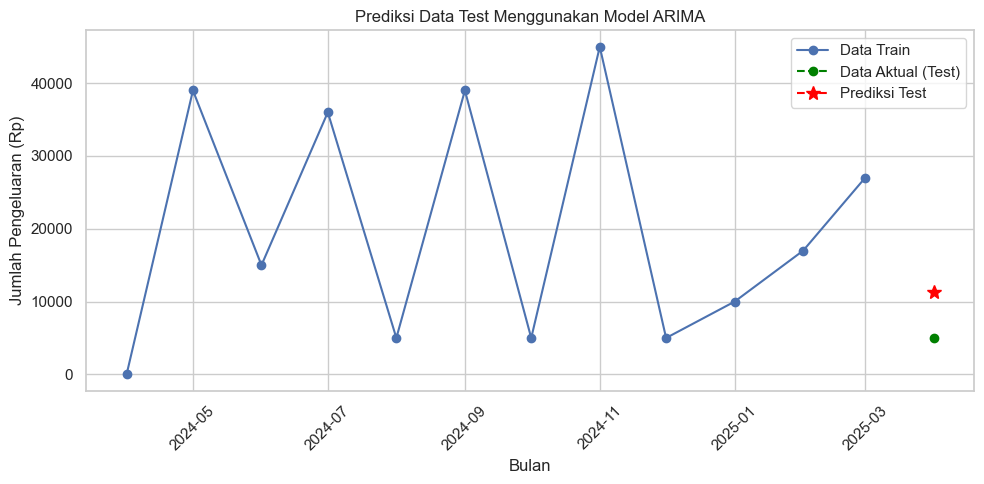

In [23]:
# Prediksi data test menggunakan model (forecast untuk 1 langkah)
pred_test_df = pd.DataFrame({
    'forecast': forecast
})

# Gabungkan train, test, dan prediksi test ke satu DataFrame
combined = pd.concat([
    train.rename('train'),
    test.rename('actual'),
    pred_test_df['forecast']
], axis=1)

# Visualisasi
plt.figure(figsize=(10, 5))

plt.plot(combined.index, combined['train'], label='Data Train', marker='o')
plt.plot(combined.index, combined['actual'], label='Data Aktual (Test)', marker='o', linestyle='--', color='green')
plt.plot(combined.index, combined['forecast'], label='Prediksi Test', marker='*', linestyle='--', markersize=10, color='red')

plt.title('Prediksi Data Test Menggunakan Model ARIMA')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Pengeluaran (Rp)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Latih model dengan seluruh data
model = ARIMA(data_kategori, order=best_cfg)
model_fit = model.fit()

# Prediksi bulan berikutnya (1 langkah ke depan)
forecast = model_fit.forecast(steps=1)

# Tanggal bulan depan
forecast_date = data_kategori.index[-1] + pd.DateOffset(months=1)
forecast_value = forecast.values[0]

print(f"Prediksi bulan {forecast_date.strftime('%B %Y')}: Rp{forecast_value:,.0f}")

Prediksi bulan May 2025: Rp28,075


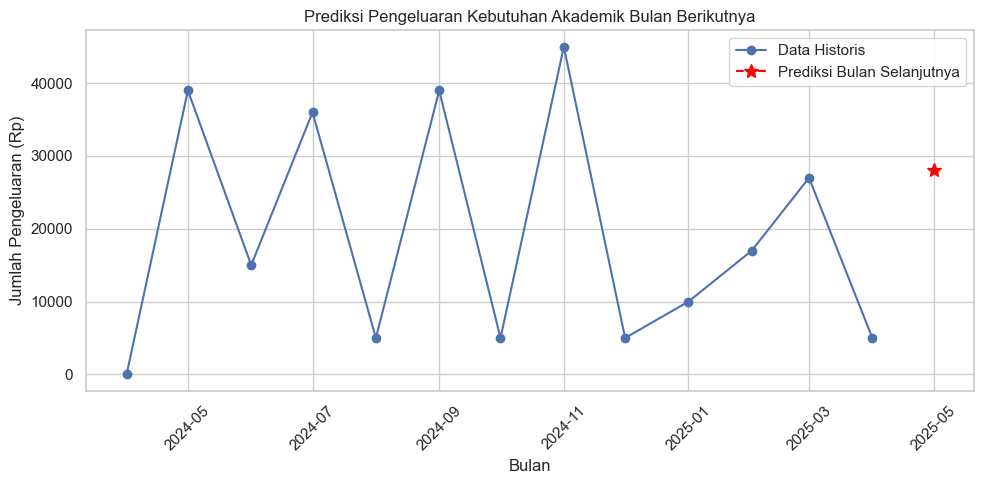

In [25]:
# Gabungkan data historis (train + test) untuk visualisasi lengkap
full_data = pd.concat([train, test])

forecast_df = pd.DataFrame({
    'jumlah': [forecast_value]
}, index=[forecast_date])

# Gabungkan data historis dan data prediksi dengan kolom sumber data
combined = pd.concat([
    full_data.rename('jumlah').to_frame().assign(source='Histori'),
    forecast_df.assign(source='Forecast')
])

# Visualisasi
plt.figure(figsize=(10, 5))
plt.plot(full_data.index, full_data.values, label='Data Historis', marker='o')
plt.plot(forecast_df.index, forecast_df['jumlah'], 
         label='Prediksi Bulan Selanjutnya', marker='*', linestyle='--', markersize=10, color='red')

plt.title(f'Prediksi Pengeluaran {kategori} Bulan Berikutnya')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Pengeluaran (Rp)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
import pickle

# Simpan model ke file
with open("kebutuhan_akademik.pkl", "wb") as file:
    pickle.dump(model_fit, file)

print("Model berhasil disimpan")

Model berhasil disimpan


In [27]:
# Muat model dari file
with open("kebutuhan_akademik.pkl", "rb") as file:
    loaded_model = pickle.load(file)